In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from astropy.table import QTable, Table

import matplotlib.pyplot as plt
import seaborn as sns

# setup

In [2]:
col_format_all_S17 = {
    'NAME':pd.StringDtype(),
    'RA':np.float64, 'DEC':np.float64,
    'PMRA':np.float32, 'PMDEC':np.float32,
    'EPOCH':np.float32, 'RESOLUTION':np.int16,
    'SUBSURVEY':pd.StringDtype(),
    'TEMPLATE':pd.StringDtype(), 
    'RULESET':pd.StringDtype(),
    'EXTENT_FLAG':np.int32,
    'EXTENT_PARAMETER':np.float32,'EXTENT_INDEX':np.float32,
    'MAG_TYPE':pd.StringDtype(),
    'MAG':np.float32, 'MAG_ERR':np.float32,
    'DATE_EARLIEST':np.float64, 'DATE_LATEST':np.float64,
    'CADENCE':np.int64,
    'REDDENING':np.float32,
    'REDSHIFT_ESTIMATE':np.float32,
    'REDSHIFT_ERROR':np.float32,
    'CAL_MAG_ID_BLUE':pd.StringDtype(),
    'CAL_MAG_ID_GREEN':pd.StringDtype(),
    'CAL_MAG_ID_RED':pd.StringDtype(),
    'CAL_MAG_ERR_BLUE':np.float32,
    'CAL_MAG_ERR_GREEN':np.float32,
    'CAL_MAG_ERR_RED':np.float32,
    'CAL_MAG_BLUE':np.float32,
    'CAL_MAG_GREEN':np.float32,
    'CAL_MAG_RED':np.float32,
    'CLASSIFICATION':pd.StringDtype(),
    # 'CLASS_SPEC':pd.StringDtype(),
    'COMPLETENESS':np.float32,
    'PARALLAX':np.float32,
    # 'SWEEP_NAME':pd.StringDtype(), 
    # 'BRICKNAME':pd.StringDtype(), 
    'TYPE':pd.StringDtype(), 
    'BAND_LEGACY':pd.StringDtype(), 
    'REFERENCE_BAND':pd.StringDtype(), 
    'COMBINATION_USE':pd.StringDtype(), 
    'REDSHIFT_REF':pd.StringDtype(), 
    'EBV':np.float64, 
    'PLXSIG': np.float64, 
    'PMSIG': np.float64, 
    'SN_MAX': np.float64, 
    'MAG_G': np.float32, 
    'MAGERR_G': np.float32, 
    'MAG_R': np.float32, 
    'MAGERR_R': np.float32, 
    'MAG_I': np.float32, 
    'MAGERR_I': np.float32, 
    'MAG_Z': np.float32, 
    'MAGERR_Z': np.float32, 
    'MAG_Y': np.float32, 
    'MAGERR_Y': np.float32, 
    'MAG_J': np.float32, 
    'MAGERR_J': np.float32, 
    'MAG_H': np.float32, 
    'MAGERR_H': np.float32, 
    'MAG_K': np.float32, 
    'MAGERR_K': np.float32, 
    'MAG_W1': np.float32, 
    'MAGERR_W1': np.float32, 
    'MAG_W2': np.float32, 
    'MAGERR_W2': np.float32, 
    'SPECTYPE_DESI': pd.StringDtype()
    }

col_units = {
    "RA": "deg", "DEC": "deg", "PMRA": "mas/yr", "PMDEC": "mas/yr",
    "EPOCH": "yr", "MAG": "mag", "MAG_ERR": "mag", "EXTENT_PARAMETER": "arcsec",
    "DATE_EARLIEST": "d", "DATE_LATEST": "d", "REDDENING": "mag",
    "CAL_MAG_BLUE": "mag", "CAL_MAG_GREEN": "mag", "CAL_MAG_RED": "mag",
    "CAL_MAG_ERR_BLUE": "mag", "CAL_MAG_ERR_GREEN": "mag", "CAL_MAG_ERR_RED": "mag",
    "PARALLAX": "mas",
}

In [3]:
def cols_format_dict(format_dict, dataframe):
    matching_columns = {}
    
    for col in dataframe.columns:
        if col in format_dict:
            matching_columns[col] = format_dict[col]
    
    return matching_columns

def format_pd_for_fits(df):
    
    df_copy = df.copy()
    
    for col_name in df_copy.columns:  # object to string

        col_values = df_copy[col_name].values

        if col_values.dtype == 'object':
            df_copy[col_name] = df_copy[col_name].astype(pd.StringDtype())

    format_cols = cols_format_dict(col_format_all_S17, df_copy)
    df_copy = df_copy.astype(format_cols)

    for col_name in df_copy.columns:  # fill empty cells

        col_series = df_copy[col_name].values

        if pd.api.types.is_string_dtype(df_copy[col_name]) or isinstance(col_series.dtype, pd.StringDtype):
            df_copy[col_name] = df_copy[col_name].fillna('-')
        else:
            if col_name in ['MAG_Z', 'MAG', 'MAGERR_Z', 'MAG_ERR', 'MAG_G', 'CAL_MAG_BLUE', 
                            'MAGERR_G', 'CAL_MAG_ERR_BLUE', 'MAG_R', 'CAL_MAG_GREEN', 'MAGERR_R', 'CAL_MAG_ERR_GREEN', 
                            'MAG_I', 'CAL_MAG_RED', 'MAGERR_I', 'CAL_MAG_ERR_RED']:
                df_copy[col_name] = df_copy[col_name].fillna(1.0)
            else:
                df_copy[col_name] = df_copy[col_name].fillna(-999)
    
    df_copy.reset_index(drop=True, inplace=True)
    return df_copy

def save_to_fits(df, filepath, meta=None):

    df_for_fits = format_pd_for_fits(df)
    
    t = Table()

    format_cols = cols_format_dict(col_format_all_S17, df_for_fits)
    for col_name in df_for_fits.columns:
        if col_name in format_cols.keys():
            col_data = df_for_fits[col_name].astype(col_format_all_S17[col_name])
            col_data = col_data.values
        else:
            col_data = df_for_fits[col_name].values

        if hasattr(col_data, 'values'):
            t[col_name] = col_data.values
        else:
            t[col_name] = [x for x in col_data]
            
    if meta:
        t.meta.update(meta)

    t.write(filepath, format='fits', overwrite=True)

def pandas_from_fits(filepath):
    t = Table.read(filepath, format='fits')
    
    t = t.to_pandas()

    format_cols = cols_format_dict(col_format_all_S17, t)
    t = t.astype(format_cols)

    return t

# Define balanced sub-catalogue

In [22]:
cat = pandas_from_fits('./../ByCycle_final.fits')

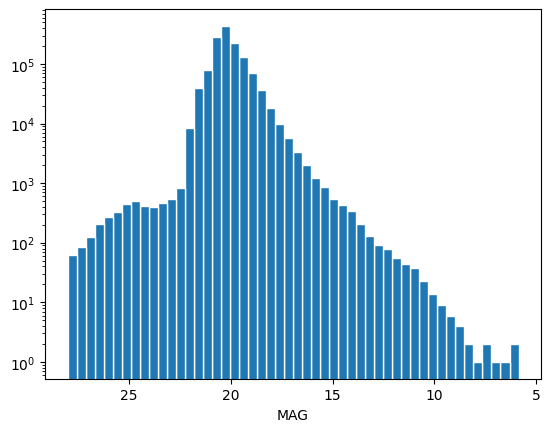

In [ ]:
cat.MAG.hist(bins=50, edgecolor='white',
             grid=False);
plt.yscale('log')

plt.xlabel('MAG')
plt.gca().invert_xaxis()

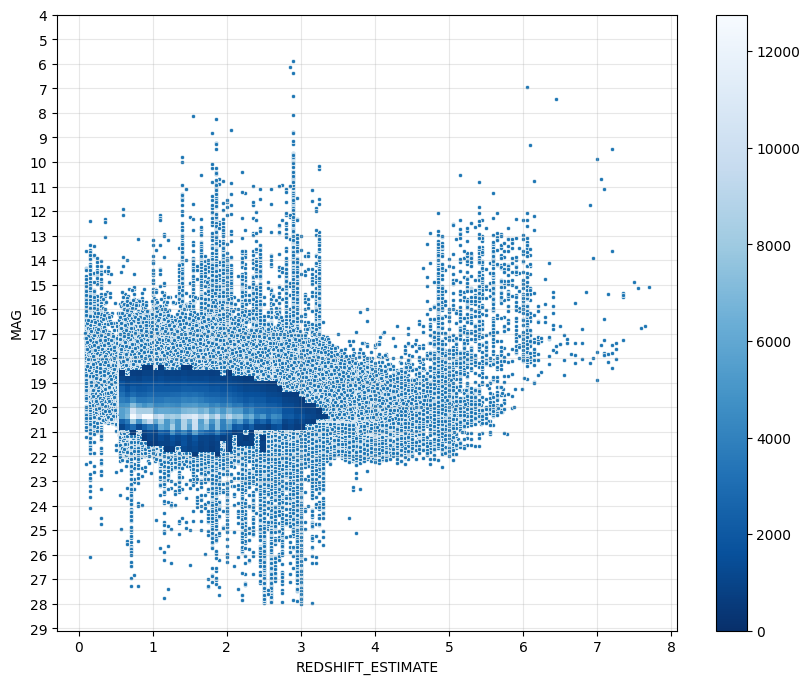

In [11]:
plt.figure(figsize=(10, 8))

sns.scatterplot(data=cat, x='REDSHIFT_ESTIMATE', y='MAG', marker='.')
sns.histplot(data=cat, x='REDSHIFT_ESTIMATE', y='MAG', bins=100, pthresh=.1, cmap="Blues_r", cbar=True)

plt.grid(True, alpha=0.3)

y_int_ticks = np.arange(int(plt.ylim()[0]), int(plt.ylim()[1])+1, 1)
plt.yticks(y_int_ticks)

plt.gca().invert_yaxis()

plt.show()

In [15]:
z_binsize = 0.10
mag_binsize = 0.2

# tails = cat.loc[(cat.REDSHIFT_ESTIMATE <= 0.2) | (cat.REDSHIFT_ESTIMATE >= 5.0)]
tails = cat.loc[cat.REDSHIFT_ESTIMATE >= 5.0]
dfs_to_concat = [tails]

# cat_all = cat.loc[(cat.REDSHIFT_ESTIMATE > 0.2) & (cat.REDSHIFT_ESTIMATE < 5.0)]
cat_all = cat.loc[cat.REDSHIFT_ESTIMATE < 5.0]

min_z = cat_all.REDSHIFT_ESTIMATE.min()
max_z = cat_all.REDSHIFT_ESTIMATE.max()

try:

    zs = np.arange(min_z, max_z, z_binsize)

    for i in range(len(zs)-1):

        # print("z range: ", zs[i], zs[i+1])
        
        sub_cat = cat_all[(cat_all.REDSHIFT_ESTIMATE>=zs[i]) & (cat_all.REDSHIFT_ESTIMATE<zs[i+1])]

        min_mag = sub_cat.MAG.min()
        max_mag = sub_cat.MAG.max()

        # print(min_mag, max_mag)

        try:

            mags = np.arange(min_mag, max_mag, mag_binsize)
            # print('mags', len(mags))

            for j in range(len(mags)-1):

                # print("range: ", mags[j], mags[j+1])

                subsub_cat = sub_cat[(sub_cat.MAG>=mags[j]) & (sub_cat.MAG<mags[j+1])]
                # print('subsub_cat', subsub_cat.shape[0])

                try: random_df = subsub_cat.sample(n=20, replace=False)
                except: random_df = subsub_cat
                # print('random_df', random_df.shape[0])

                # cat_bal = cat_bal.append(random_df, ignore_index=True)
                # cat_bal = pd.concat([cat_bal, random_df], ignore_index=True, axis=1)
                dfs_to_concat.append(random_df)

        except: print("could not create MAG bins")

except: print("could not create z bins")

cat_bal = pd.concat(dfs_to_concat, ignore_index=True)

In [16]:
cat_bal.shape

(31685, 35)

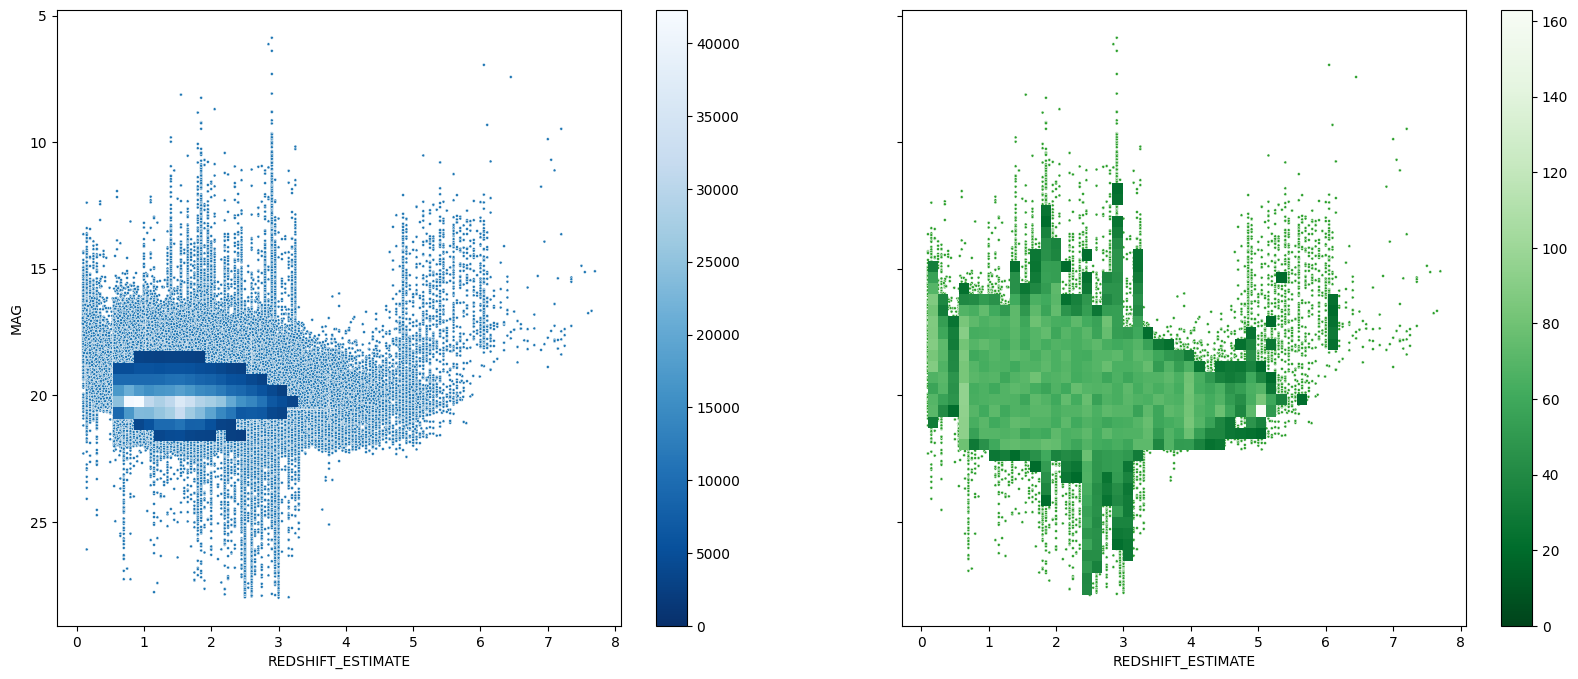

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20, 8))

sns.scatterplot(data=cat, x='REDSHIFT_ESTIMATE', y='MAG', marker='.', ax=ax1, c='C0', size=1, legend=False)
sns.histplot(data=cat, x='REDSHIFT_ESTIMATE', y='MAG', bins=50, pthresh=.1, cmap="Blues_r", cbar=True, ax=ax1)

sns.scatterplot(data=cat_bal, x='REDSHIFT_ESTIMATE', y='MAG', marker='.', ax=ax2, c='C2', size=1, legend=False)
sns.histplot(data=cat_bal, x='REDSHIFT_ESTIMATE', y='MAG', bins=50, pthresh=.1, cmap="Greens_r", cbar=True, ax=ax2)

ax1.set_gid(True)
ax2.set_gid(True)

plt.gca().invert_yaxis()

plt.show()

<Axes: >

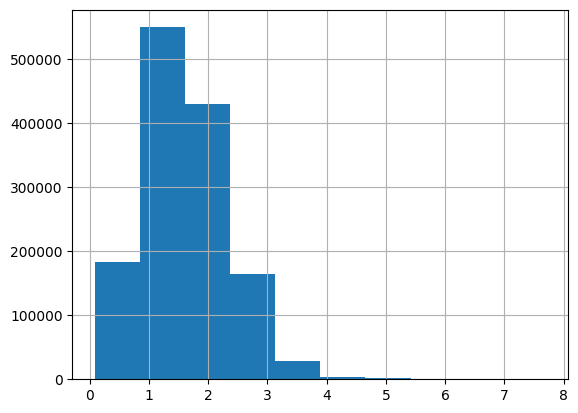

In [21]:
cat.REDSHIFT_ESTIMATE.hist()

<Axes: >

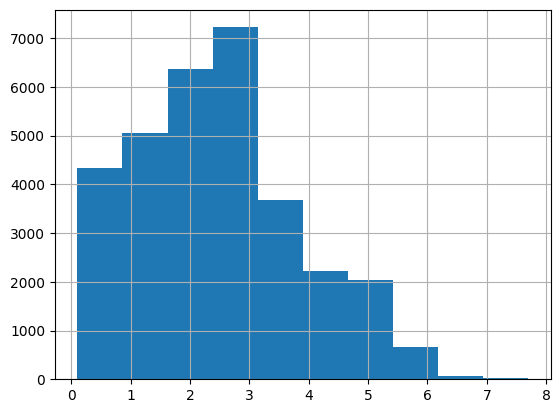

In [19]:
cat_bal.REDSHIFT_ESTIMATE.hist()

<Axes: >

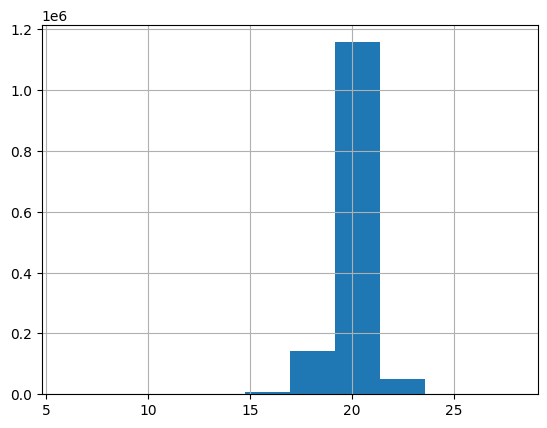

In [22]:
cat.MAG.hist()

<Axes: >

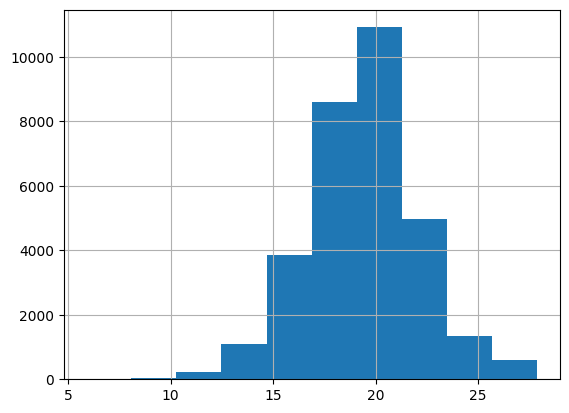

In [20]:
cat_bal.MAG.hist()

In [ ]:
save_to_fits(cat_bal, './../ByCycle_balanced_subset_QSOs.fits')

# Change template name in cat to its simulated QSO

In [4]:
cat_bal = pandas_from_fits('./../ByCycle_balanced_subset_QSOs.fits')
cat_bal

,NAME,RA,DEC,PMRA,PMDEC,EPOCH,RESOLUTION,SUBSURVEY,TEMPLATE,RULESET,...,CAL_MAG_RED,CAL_MAG_ERR_BLUE,CAL_MAG_ERR_GREEN,CAL_MAG_ERR_RED,CAL_MAG_ID_BLUE,CAL_MAG_ID_GREEN,CAL_MAG_ID_RED,CLASSIFICATION,COMPLETENESS,PARALLAX
0,MgIIBlueDeep_3.797m32.0845,3.797036,-32.084532,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z7_0_000001.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.582340,29.000000,0.113706,0.060229,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1,MgIIBlueDeep_3.8049m32.078,3.804881,-32.078050,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z7_1_000002.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.408802,29.000000,0.103468,0.029969,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
2,MgIIBlueDeep_4.045m30.4084,4.045017,-30.408356,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z5_35_000003.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.680607,0.052875,0.023544,0.005908,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
3,MgIIBlueDeep_4.9565m34.0107,4.956523,-34.010734,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z5_15_000004.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.239796,0.676440,0.026675,0.006518,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
4,MgIIBlueDeep_2.1999m35.3336,2.199921,-35.333618,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z5_9_000005.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,16.874743,29.000000,0.002459,0.000740,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31680,MgIIBlueDeep_151.2334p2.5492,151.233402,2.549189,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_9_031681.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.938766,2.205216,0.042353,0.014130,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31681,MgIIBlueDeep_176.279p2.1823,176.279032,2.182282,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_9_031682.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.854259,29.000000,0.359425,0.184809,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31682,MgIIBlueDeep_22.7516m27.4173,22.751601,-27.417298,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_95_031683.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.629225,29.000000,0.146640,0.040198,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31683,MgIIBlueDeep_199.3501p2.3258,199.350097,2.325767,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_9_031684.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.753094,29.000000,0.466469,0.146729,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0


In [14]:
qsos = pd.read_csv('../QSO_output/simulated_QSOs/model_input.csv')
qsos

,ID,REDSHIFT,absMag,smcDustEBV,LOG_MBH,LOG_REDD,NAME
0,QSO_z7_0_000001,7.00,-27.072248,0.033944,8.941197,0.001523,MgIIBlueDeep_3.797m32.0845
1,QSO_z7_1_000002,7.10,-23.941723,0.078066,8.833184,-1.142675,MgIIBlueDeep_3.8049m32.078
2,QSO_z5_35_000003,5.35,-24.236923,0.025737,8.629976,-0.821387,MgIIBlueDeep_4.045m30.4084
3,QSO_z5_15_000004,5.15,-24.830811,0.002427,8.388963,-0.342819,MgIIBlueDeep_4.9565m34.0107
4,QSO_z5_9_000005,5.90,-25.169991,0.217242,8.929093,-0.747277,MgIIBlueDeep_2.1999m35.3336
...,...,...,...,...,...,...,...
31680,QSO_z4_9_031681,4.90,-23.747080,0.058224,8.668739,-1.056087,MgIIBlueDeep_151.2334p2.5492
31681,QSO_z4_9_031682,4.90,-23.237442,0.032982,8.233691,-0.824894,MgIIBlueDeep_176.279p2.1823
31682,QSO_z4_95_031683,4.95,-24.151350,0.053382,8.369871,-0.595511,MgIIBlueDeep_22.7516m27.4173
31683,QSO_z4_9_031684,4.90,-23.303242,0.076551,8.078558,-0.643441,MgIIBlueDeep_199.3501p2.3258


In [16]:
cat_bal['TEMPLATE'] = qsos.loc[qsos['NAME']==cat_bal['NAME'], 'ID'] + '.fits'
cat_bal

,NAME,RA,DEC,PMRA,PMDEC,EPOCH,RESOLUTION,SUBSURVEY,TEMPLATE,RULESET,...,CAL_MAG_RED,CAL_MAG_ERR_BLUE,CAL_MAG_ERR_GREEN,CAL_MAG_ERR_RED,CAL_MAG_ID_BLUE,CAL_MAG_ID_GREEN,CAL_MAG_ID_RED,CLASSIFICATION,COMPLETENESS,PARALLAX
0,MgIIBlueDeep_3.797m32.0845,3.797036,-32.084532,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z7_0_000001.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.582340,29.000000,0.113706,0.060229,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1,MgIIBlueDeep_3.8049m32.078,3.804881,-32.078050,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z7_1_000002.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.408802,29.000000,0.103468,0.029969,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
2,MgIIBlueDeep_4.045m30.4084,4.045017,-30.408356,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z5_35_000003.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.680607,0.052875,0.023544,0.005908,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
3,MgIIBlueDeep_4.9565m34.0107,4.956523,-34.010734,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z5_15_000004.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.239796,0.676440,0.026675,0.006518,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
4,MgIIBlueDeep_2.1999m35.3336,2.199921,-35.333618,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z5_9_000005.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,16.874743,29.000000,0.002459,0.000740,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31680,MgIIBlueDeep_151.2334p2.5492,151.233402,2.549189,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_9_031681.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.938766,2.205216,0.042353,0.014130,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31681,MgIIBlueDeep_176.279p2.1823,176.279032,2.182282,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_9_031682.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.854259,29.000000,0.359425,0.184809,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31682,MgIIBlueDeep_22.7516m27.4173,22.751601,-27.417298,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_95_031683.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.629225,29.000000,0.146640,0.040198,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31683,MgIIBlueDeep_199.3501p2.3258,199.350097,2.325767,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_9_031684.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.753094,29.000000,0.466469,0.146729,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0


In [5]:
cat_bal

,NAME,RA,DEC,PMRA,PMDEC,EPOCH,RESOLUTION,SUBSURVEY,TEMPLATE,RULESET,...,CAL_MAG_RED,CAL_MAG_ERR_BLUE,CAL_MAG_ERR_GREEN,CAL_MAG_ERR_RED,CAL_MAG_ID_BLUE,CAL_MAG_ID_GREEN,CAL_MAG_ID_RED,CLASSIFICATION,COMPLETENESS,PARALLAX
0,MgIIBlueDeep_3.797m32.0845,3.797036,-32.084532,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z7_0_000001.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.582340,29.000000,0.113706,0.060229,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
1,MgIIBlueDeep_3.8049m32.078,3.804881,-32.078050,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z7_1_000002.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.408802,29.000000,0.103468,0.029969,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
2,MgIIBlueDeep_4.045m30.4084,4.045017,-30.408356,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z5_35_000003.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,19.680607,0.052875,0.023544,0.005908,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
3,MgIIBlueDeep_4.9565m34.0107,4.956523,-34.010734,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z5_15_000004.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,20.239796,0.676440,0.026675,0.006518,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
4,MgIIBlueDeep_2.1999m35.3336,2.199921,-35.333618,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z5_9_000005.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,16.874743,29.000000,0.002459,0.000740,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31680,MgIIBlueDeep_151.2334p2.5492,151.233402,2.549189,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_9_031681.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.938766,2.205216,0.042353,0.014130,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31681,MgIIBlueDeep_176.279p2.1823,176.279032,2.182282,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_9_031682.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.854259,29.000000,0.359425,0.184809,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31682,MgIIBlueDeep_22.7516m27.4173,22.751601,-27.417298,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_95_031683.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.629225,29.000000,0.146640,0.040198,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0
31683,MgIIBlueDeep_199.3501p2.3258,199.350097,2.325767,0.0,0.0,2000.0,2,MgIIBlueDeep,QSO_z4_9_031684.fits,Fixed_BG_NOISE_0p33hr_Rulesets,...,21.753094,29.000000,0.466469,0.146729,DECAM_G_AB_PSF,DECAM_R_AB_PSF,DECAM_I_AB_PSF,AGN,1.0,0.0


In [ ]:
# save_to_fits(cat_bal, './../ByCycle_balanced_subset_QSOs.fits')

In [14]:
Counter(cat_bal.SUBSURVEY)

Counter({'MgIIGreen': 9727,
         'DLABlue': 6628,
         'MgIIBlueDeep': 6459,
         'MgIIBlueWide': 4552,
         'LLSBlue': 4319})

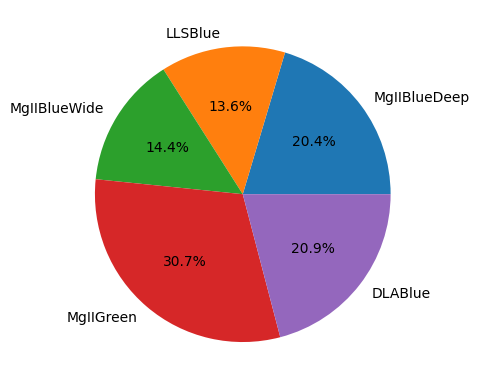

In [16]:
fig, ax = plt.subplots()
ax.pie(Counter(cat_bal.SUBSURVEY).values(), labels=Counter(cat_bal.SUBSURVEY).keys(), autopct='%1.1f%%')
plt.show()

In [10]:
1.2 * (31685 / 10) / 3600  # hours for ETC

1.0561666666666667

# Fobs

In [ ]:
fobs = Table.read('./../fobs_stats.fits', format='fits').to_pandas()
fobs

,targ_id,fobs>0.0,fobs>0.5,fobs>0.7,fobs>0.8,fobs>0.9,fobs>1.0
0,9,2.462690e+06,2.462690e+06,2.462690e+06,2.462690e+06,2.462690e+06,NaN
1,11,2.462690e+06,2.462690e+06,2.462690e+06,2.462690e+06,2.462690e+06,2.462690e+06
2,12,2.462690e+06,2.462690e+06,2.462690e+06,2.462690e+06,2.462690e+06,2.462690e+06
3,13,2.462071e+06,2.462071e+06,2.462071e+06,2.462071e+06,NaN,NaN
4,14,2.462071e+06,2.462071e+06,2.462071e+06,2.462071e+06,2.462071e+06,NaN
...,...,...,...,...,...,...,...
36995244,53513270,2.460988e+06,2.460988e+06,2.460988e+06,2.460988e+06,2.460988e+06,2.460988e+06
36995245,53513271,2.462005e+06,2.462005e+06,2.462005e+06,2.462005e+06,2.462005e+06,2.462005e+06
36995246,53513272,2.461317e+06,2.461317e+06,2.461317e+06,2.461317e+06,2.461317e+06,2.461317e+06
36995247,53513273,2.460875e+06,2.460875e+06,2.460875e+06,2.460875e+06,2.460875e+06,2.460875e+06


In [16]:
fobs.shape[0]

36995249